In [190]:
import numpy as np
from scipy.optimize import minimize, least_squares, brute

In [191]:
from typing import Callable, Tuple, List
import pandas as pd

In [192]:
import random

In [193]:
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['font.size'] = 22

In [194]:
EPS = 1e-3

In [195]:
def plot_scatter_with_trends(x: List[float], y: List[float], trends: List[Tuple[List[float], List[float], str]], title: str):
    plt.scatter(x, y, label="generated data")
    for x, y, label in trends:
        plt.plot(x, y, label=label)
    plt.title(title)
    plt.legend(loc='upper left')
    plt.show()

In [196]:
def run_brute(method: str,
              f: Callable[[float], float],
              jac: Callable[[float], float],
              x0: List[Tuple[float, float]],
              ranges: List[Tuple[float, float]], 
              tol: float) -> Tuple[float, int]:
    Ns = int(np.ceil((ranges[0][1] - ranges[0][0]) / tol))
    return brute(func=f, ranges=ranges, Ns=Ns, finish=None), 1

In [197]:
def run_minimize(method: str, 
                 f: Callable[[float], float], 
                 jac: Callable[[float], float],
                 x0: List[Tuple[float, float]],
                 ranges: List[Tuple[float, float]], 
                 tol: float) -> Tuple[float, int]:
    res = minimize(method=method, fun=f, x0=x0, bounds=ranges, tol=tol, jac=jac)
    return res.x, res.nit

In [198]:
def run_least_squares(method: str, 
                      f: Callable[[float], float],
                      jac: Callable[[float], float],
                      x0: List[Tuple[float, float]],
                      ranges: List[Tuple[float, float]], 
                      tol: float) -> Tuple[float, int]:
    res = least_squares(method=method, fun=f, x0=x0, xtol=tol)
    return res.x, res.nfev

In [199]:
def run_gradient_descent(method: str, 
                        f: Callable[[float], float],
                        jac: Callable[[float], float],
                        x0: List[Tuple[float, float]],
                        ranges: List[Tuple[float, float]], 
                        tol: float, 
                        learning_rate = 1e-2, 
                        max_epochs = 1e8) -> Tuple[float, int]:
    it = 0
    while it < max_epochs:
        it += 1
        delta = learning_rate * jac(x0)
        if np.all(np.abs(delta) < tol / 10):
            break
        x0 -= delta
        
    return x0, it

In [200]:
methods = [('CG', run_minimize), 
           ('Newton-CG', run_minimize), 
           ('lm', run_least_squares),
           ('GD', run_gradient_descent),
           ('Powell', run_minimize),
           ('Nelder-Mead', run_minimize),
           ('brute', run_brute)
          ]

In [201]:
def run_f(f: Callable[[float], float], x: float, inv: List[int]) -> float:
    inv[0] += 1
    return f(x)

In [202]:
def run_optimization(optimizer, 
                     method: str,
                     f: Callable[[float], float], 
                     jac: Callable[[float], float],
                     x0: List[Tuple[float, float]],
                     ranges: List[Tuple[float, float]], 
                     tol: float) -> Tuple[float, int, int]:
    inv = [0]
    opt, it = optimizer(method, lambda x: run_f(f, x, inv), jac, x0, ranges, tol)
    return opt, it, inv[0]

In [203]:
N = 100
alpha, beta = random.uniform(0, 1), random.uniform(0, 1)
x = np.array([k / 100 for k in range(N)])
y = alpha * x + beta + np.random.normal(0, 1, N)

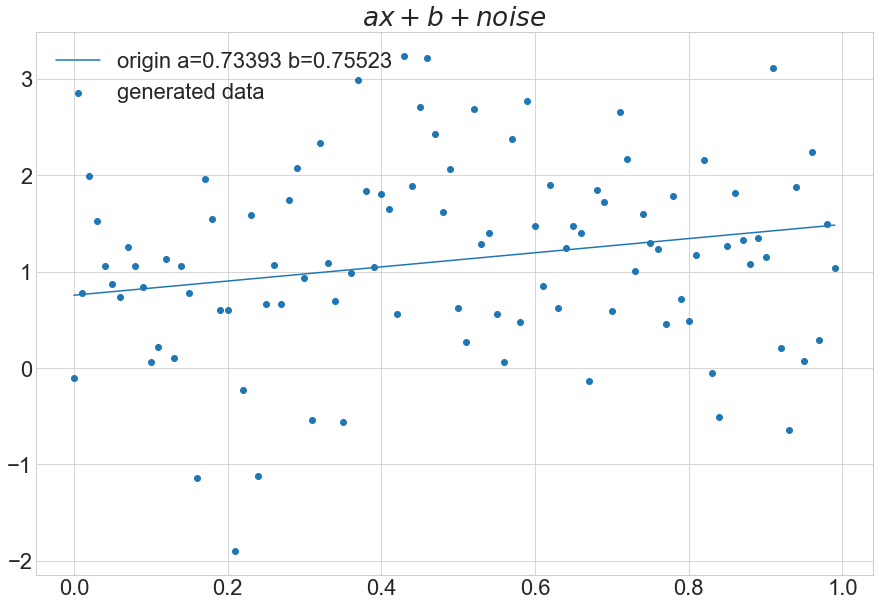

In [204]:
plot_scatter_with_trends(x, y, [(x, alpha * x + beta, "origin" + (" a=%.5f b=%.5f" % (alpha, beta)))], '$ax + b + noise$')

In [205]:
def d(f, a, b, x, y):
    return (np.square(f(x, a, b) - y)).mean(axis=0)

def d_jac(f, f_jac, a, b, x, y):
    d_df = np.full(x.shape, 2 * (f(x, a, b) - y))
    df = f_jac(x, a, b)
    return np.array([(d_df * df[0]).mean(axis=0), (d_df * df[1]).mean(axis=0)])

In [206]:
def minimize_multidimensional_function(f_: Callable[[float, float, float], float], 
                                       f_jac_: Callable[[float, float, float], float],
                                       f_ranges: List[Tuple[float, float]], f_name: str) -> pd.DataFrame:
    
    results = []
    trends = [(x, alpha * x + beta, "origin")]
    x0 = np.array([random.uniform(low, hight) for low, hight in f_ranges])
    
    for method, optimizer in methods:
        if method == 'lm':
            f = lambda p: f_(x, p[0], p[1]) - y
            jac = lambda p: f_jac_(x, p[0], p[1])
        else:
            f = lambda p: d(f_, p[0], p[1], x, y)
            jac = lambda p: d_jac(f_, f_jac_, p[0], p[1], x, y)
            
        opt, it, inv = run_optimization(optimizer, method, f, jac, x0, f_ranges, EPS)
        mse = d(f_, opt[0], opt[1], x, y)
        results.append([f'${f_name}$', method, f_ranges, np.around(opt, 5), mse, it, inv])
        trends.append((x, f_(x, opt[0], opt[1]), method))
    
    plot_scatter_with_trends(x, y, trends, f_name)
    df = pd.DataFrame.from_records(results, columns=['function', 'method', 'range', '[a, b]', 'mse', 'iteratins', 'invocations'])
    return df

/usr/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/var/folders/4s/hl9y6lqs3h1c9qxxnbjmtvsr0000gn/T/ipykernel_14802/2148284058.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([x, 1])
/usr/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Newton-CG cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/usr/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:519: RuntimeWarning: Method Powell does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


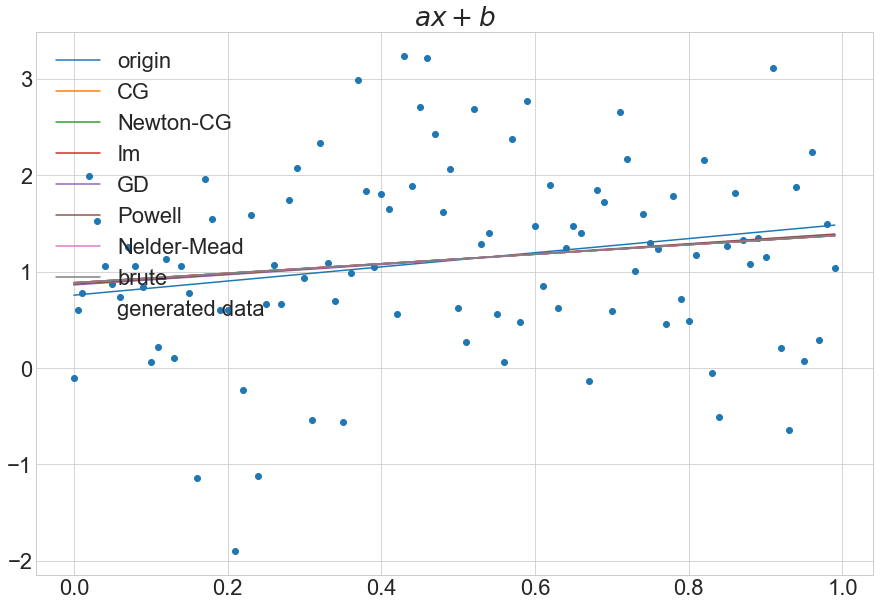

,function,method,range,"[a, b]",mse,iteratins,invocations
0,$$ax + b$$,CG,"[[0, 1], [0, 1]]","[0.49745, 0.88193]",0.916395,3,7
1,$$ax + b$$,Newton-CG,"[[0, 1], [0, 1]]","[0.49218, 0.8848]",0.916393,3,4
2,$$ax + b$$,lm,"[[0, 1], [0, 1]]","[0.49218, 0.8848]",0.916393,6,13
3,$$ax + b$$,GD,"[[0, 1], [0, 1]]","[0.52805, 0.86205]",0.916525,196,0
4,$$ax + b$$,Powell,"[[0, 1], [0, 1]]","[0.52646, 0.86782]",0.916491,1,13
5,$$ax + b$$,Nelder-Mead,"[[0, 1], [0, 1]]","[0.49246, 0.88455]",0.916393,18,35
6,$$ax + b$$,brute,"[[0, 1], [0, 1]]","[0.49249, 0.88488]",0.916393,1,1000000


In [207]:
def f1(x, a, b):
    return a * x + b

def f1_jac(x, a, b):
    return np.array([x, 1])

functin = (f1, f1_jac, [[0, 1], [0, 1]], '$ax + b$')
minimize_multidimensional_function(*functin)

/usr/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/usr/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Newton-CG cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/usr/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:519: RuntimeWarning: Method Powell does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,
/usr/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:519: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,
/usr/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Met

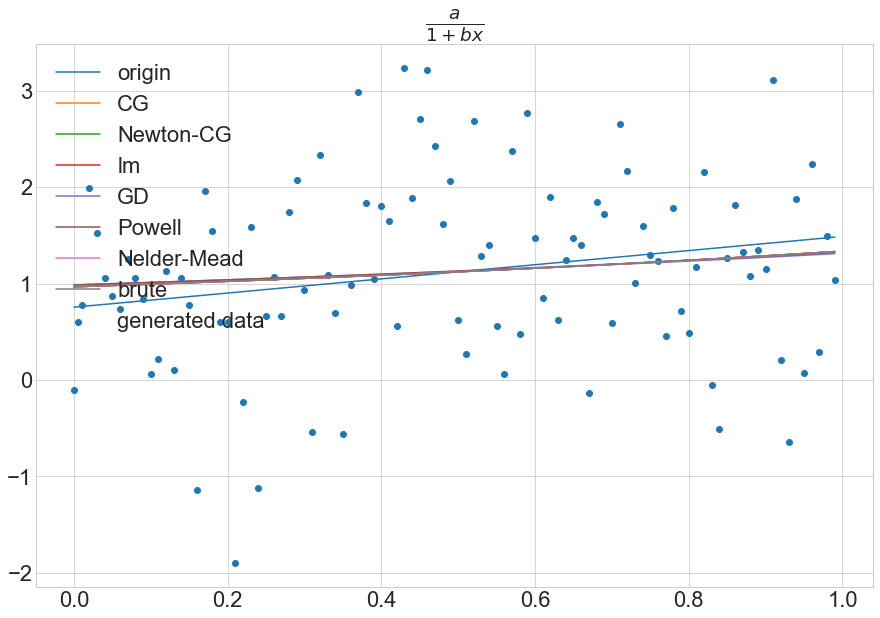

,function,method,range,"[a, b]",mse,iteratins,invocations
0,$$\frac{a}{1 + bx}$$,CG,"[[-1, 1], [-1, 1]]","[0.96681, -0.27692]",0.921494,8,17
1,$$\frac{a}{1 + bx}$$,Newton-CG,"[[-1, 1], [-1, 1]]","[0.9668, -0.27692]",0.921494,9,11
2,$$\frac{a}{1 + bx}$$,lm,"[[-1, 1], [-1, 1]]","[0.96677, -0.27697]",0.921494,53,60
3,$$\frac{a}{1 + bx}$$,GD,"[[-1, 1], [-1, 1]]","[0.98806, -0.24858]",0.921717,1390,0
4,$$\frac{a}{1 + bx}$$,Powell,"[[-1, 1], [-1, 1]]","[0.98529, -0.25771]",0.921640,1,22
5,$$\frac{a}{1 + bx}$$,Nelder-Mead,"[[-1, 1], [-1, 1]]","[0.96684, -0.27669]",0.921494,16,31
6,$$\frac{a}{1 + bx}$$,brute,"[[-1, 1], [-1, 1]]","[0.96698, -0.27664]",0.921494,1,4000000


In [208]:
def f2(x, a, b):
    return a / (1 + x * b)

def f2_jac(x, a, b):
    return np.array([1.0 / (1 + x * b), - x * a / ((1 + x * b) ** 2)])

fuction = (f2, f2_jac, [[-1, 1], [-1, 1]], r'$\frac{a}{1 + bx}$')
minimize_multidimensional_function(*fuction)